In [3]:
# Core ML & NLP
!pip install -q torch torchvision torchaudio
!pip install -q transformers datasets accelerate evaluate

# Data processing
!pip install -q pandas numpy scikit-learn
!pip install -q nltk regex emoji

# Visualization
!pip install -q matplotlib seaborn

# Utilities
!pip install -q tqdm rich

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 38.3 MB/s eta 0:00:00


# **Load data**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import emoji
import re
from google.colab import drive

# 1. Mount Google Drive
print("--- Mounting Google Drive ---")
drive.mount('/content/drive')
print("--- Google Drive Mounted ---")

# 2. Load Dataset from Google Drive
# GoEmotions Datasets
df_go_emotions_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/goemotion/go_emotions_test.csv')
df_go_emotions_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/goemotion/go_emotions_train.csv')
df_go_emotions_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/goemotion/go_emotions_validation.csv')

# TweetEval Datasets
df_tweet_eval_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/tweeteval/sentiment_test.csv')
df_tweet_eval_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/tweeteval/sentiment_train.csv')
df_tweet_eval_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/tweeteval/sentiment_validation.csv')

# 3. Preliminary data check
print("\n--- GoEmotions Train Data (first 5 rows) ---")
print(f"Size: {len(df_go_emotions_train)}")
print(df_go_emotions_train.head())

print("\n--- TweetEval Train Data (first 5 rows) ---")
print(f"Size: {len(df_tweet_eval_train)}")
print(df_tweet_eval_train.head())

--- Mounting Google Drive ---
Mounted at /content/drive
--- Google Drive Mounted ---

--- GoEmotions Train Data (first 5 rows) ---
Size: 43410
                                                text labels       id
0  My favourite food is anything I didn't have to...   [27]  eebbqej
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj
3                        To make her feel threatened   [14]  ed7ypvh
4                             Dirty Southern Wankers    [3]  ed0bdzj

--- TweetEval Train Data (first 5 rows) ---
Size: 45615
                                                text  label
0  "QT @user In the original draft of the 7th boo...      2
1  "Ben Smith / Smith (concussion) remains out of...      1
2  Sorry bout the stream last night I crashed out...      1
3  Chase Headley's RBI double in the 8th inning o...      1
4  @user Alciato: Bee will invest 150 million in ...      2


# **EDA**

In [5]:
# =========================
# EDA - Helper Functions
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import emoji
import re
import ast

def _detect_text_col(df):
    for c in ["text", "sentence", "content", "tweet"]:
        if c in df.columns: return c
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    return obj_cols[0] if obj_cols else df.columns[0]

def _detect_label_col(df, text_col):
    # common label col names
    for c in ["label", "labels", "sentiment", "target", "y"]:
        if c in df.columns: return c
    # pick a numeric small-cardinality col (excluding obvious ids)
    ignore = {text_col, "id", "idx", "example_id", "split"}
    candidates = [c for c in df.columns if c not in ignore and pd.api.types.is_numeric_dtype(df[c])]
    if candidates:
        # choose col with smallest unique count (but >1)
        best = sorted(candidates, key=lambda c: (df[c].nunique(), -df[c].count()))[0]
        return best
    return None

def _detect_goemotion_labels(df, text_col):
    # Case A: multilabel stored in a single column (common names: labels, label)
    for c in ["labels", "label"]:
        if c in df.columns:
            # try parse if it's list-like strings, else treat as single label column
            sample = df[c].dropna().astype(str).head(5).tolist()
            if any(s.strip().startswith("[") and s.strip().endswith("]") for s in sample):
                return {"type": "list_column", "col": c}
            # if numeric 0/1 single label column doesn't fit GoEmotions (usually multi-label)
            # but still handle it as single-label
            return {"type": "single_label", "col": c}

    # Case B: one-hot columns (0/1) across many emotion columns
    ignore = {text_col, "id", "idx", "example_id", "split"}
    cand = [c for c in df.columns if c not in ignore]
    onehot = []
    for c in cand:
        if pd.api.types.is_numeric_dtype(df[c]):
            vals = set(pd.Series(df[c].dropna().unique()).head(50).tolist())
            if vals.issubset({0, 1}):
                onehot.append(c)
    # prefer many columns
    if len(onehot) >= 5:
        return {"type": "onehot", "cols": onehot}

    return {"type": "unknown"}

def _basic_text_features(series: pd.Series):
    s = series.fillna("").astype(str)
    lengths = s.str.len()
    word_counts = s.str.split().apply(len)
    return lengths, word_counts

def _extract_social_tokens(texts: pd.Series):
    texts = texts.fillna("").astype(str)

    url_pat = re.compile(r"(https?://\S+|www\.\S+)")
    mention_pat = re.compile(r"@\w+")
    hashtag_pat = re.compile(r"#\w+")
    emoji_counter = Counter()
    url_counter = Counter()
    mention_counter = Counter()
    hashtag_counter = Counter()

    for t in texts.tolist():
        # emojis
        for e in emoji.emoji_list(t):
            emoji_counter[e["emoji"]] += 1
        # urls, mentions, hashtags
        for u in url_pat.findall(t):
            url_counter[u] += 1
        for m in mention_pat.findall(t):
            mention_counter[m.lower()] += 1
        for h in hashtag_pat.findall(t):
            hashtag_counter[h.lower()] += 1

    return emoji_counter, url_counter, mention_counter, hashtag_counter

=== GoEmotions Train EDA ===
Text column: text
Label format: {'type': 'list_column', 'col': 'labels'}

--- Missing values (top) ---


,missing_ratio
text,0.0
labels,0.0
id,0.0



Duplicate texts: 183 / 43410 (0.42%)

--- Text length stats ---


,char_len,word_len
count,43410.000000,43410.000000
mean,68.400875,12.840175
std,36.721898,6.701597
min,2.000000,1.000000
25%,38.000000,7.000000
50%,65.000000,12.000000
75%,96.000000,18.000000
90%,120.000000,22.000000
95%,131.000000,24.000000
99%,151.000000,27.000000


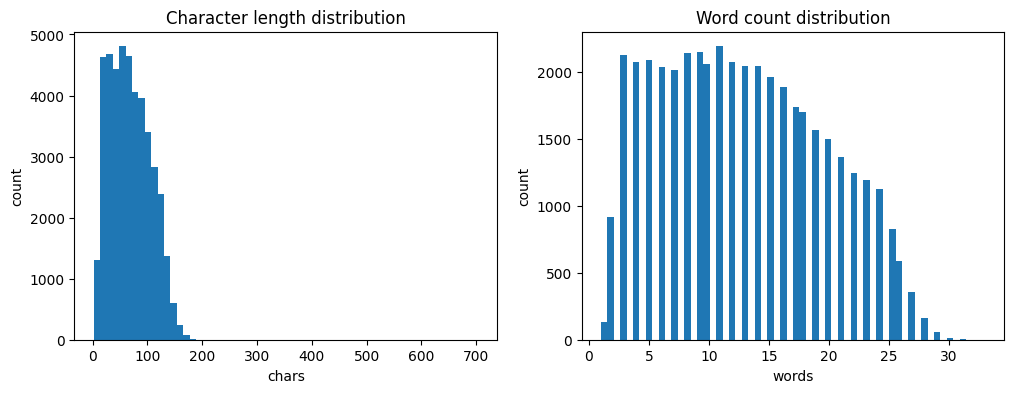


--- Multi-label density ---


,labels_per_sample
count,43410.000000
mean,1.177217
std,0.417699
min,1.000000
50%,1.000000
75%,1.000000
90%,2.000000
95%,2.000000
99%,3.000000
max,5.000000



--- Top 20 labels (frequency) ---


,count
27,14219
0,4130
4,2939
15,2662
3,2470
1,2328
7,2191
18,2086
10,2022
20,1581


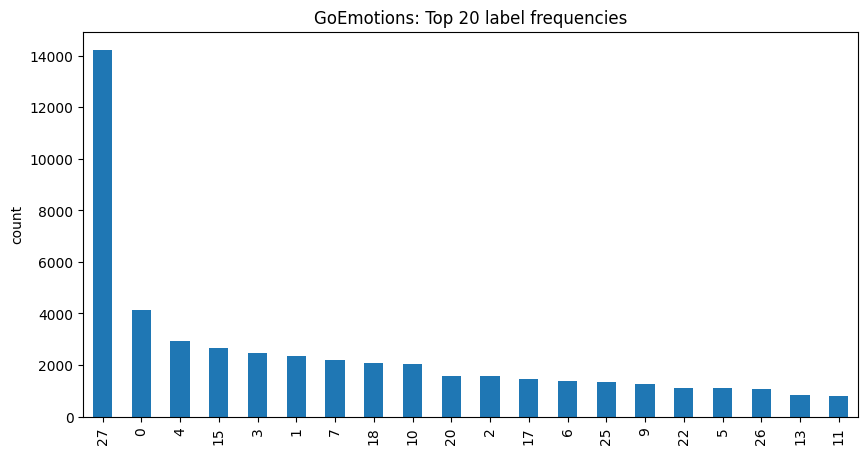


--- Top emojis ---


,emoji,count
0,😂,229
1,❤️,60
2,🤣,58
3,😭,39
4,👏,37
5,😍,33
6,🤔,29
7,🦀,29
8,❤,25
9,👍,20



--- Random samples ---


,text,labels
43018,Yeah maybe they'll finally get a shred of evid...,[1]
36670,Thank you!! This is so helpful,[15]
11941,Yes my man,[17]
4930,So happy for [NAME]. So sad he's not here. Ima...,"[17, 25]"
9741,Interesting!!,[13]
26991,That was my favorite PS1 game.,[18]
21214,That right hand sent our dad flying across the...,[1]
33899,"In addition to poor judgement, she is incapabl...",[27]


In [6]:
# =========================
# GoEmotions EDA - Analysis (Train Set)
# =========================

# Using df_go_emotions_train directly instead of combining splits
df_analyze = df_go_emotions_train.copy()

text_col = _detect_text_col(df_analyze)
label_info = _detect_goemotion_labels(df_analyze, text_col)

print("=== GoEmotions Train EDA ===")
print("Text column:", text_col)
print("Label format:", label_info)

# 1. Missing / duplicates
print("\n--- Missing values (top) ---")
display(df_analyze.isna().mean().sort_values(ascending=False).head(10).to_frame("missing_ratio"))

dup_cnt = df_analyze.duplicated(subset=[text_col]).sum()
print(f"\nDuplicate texts: {dup_cnt} / {len(df_analyze)} ({dup_cnt/len(df_analyze):.2%})")

# 2. Text length stats
char_len, word_len = _basic_text_features(df_analyze[text_col])
print("\n--- Text length stats ---")
display(pd.DataFrame({
    "char_len": char_len.describe(percentiles=[.25,.5,.75,.9,.95,.99]),
    "word_len": word_len.describe(percentiles=[.25,.5,.75,.9,.95,.99]),
}))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(char_len, bins=60)
plt.title("Character length distribution")
plt.xlabel("chars"); plt.ylabel("count")

plt.subplot(1, 2, 2)
plt.hist(word_len, bins=60)
plt.title("Word count distribution")
plt.xlabel("words"); plt.ylabel("count")
plt.show()

# 3. Label Analysis
if label_info["type"] == "list_column":
    col = label_info["col"]
    parsed = df_analyze[col].fillna("[]").astype(str).apply(lambda x: ast.literal_eval(x) if x.strip().startswith("[") else [])
    labels_per_sample = parsed.apply(len)

    print("\n--- Multi-label density ---")
    display(labels_per_sample.describe(percentiles=[.5,.75,.9,.95,.99]).to_frame("labels_per_sample"))

    # Flatten labels
    all_labels = [l for sublist in parsed for l in sublist]
    label_counts = pd.Series(all_labels).value_counts()

    print("\n--- Top 20 labels (frequency) ---")
    display(label_counts.head(20).to_frame("count"))

    plt.figure(figsize=(10, 5))
    label_counts.head(20).plot(kind='bar')
    plt.title("GoEmotions: Top 20 label frequencies")
    plt.ylabel("count")
    plt.show()

# 4. Social Tokens
emoji_c, url_c, mention_c, hashtag_c = _extract_social_tokens(df_analyze[text_col])
print("\n--- Top emojis ---")
display(pd.DataFrame(emoji_c.most_common(20), columns=["emoji", "count"]))

print("\n--- Random samples ---")
display(df_analyze[[text_col] + ([label_info['col']] if 'col' in label_info else [])].sample(8))

=== TweetEval Sentiment EDA ===
Text column: text
Label column: label

--- Missing values (top) ---


,missing_ratio
text,0.0
label,0.0



Duplicate texts: 29 / 45615 (0.06%)

--- Text length stats ---


,char_len,word_len
count,45615.000000,45615.000000
mean,106.932851,19.237444
std,26.251517,4.935990
min,10.000000,1.000000
25%,89.000000,16.000000
50%,113.000000,20.000000
75%,128.000000,23.000000
90%,138.000000,25.000000
95%,141.000000,27.000000
99%,150.000000,29.000000


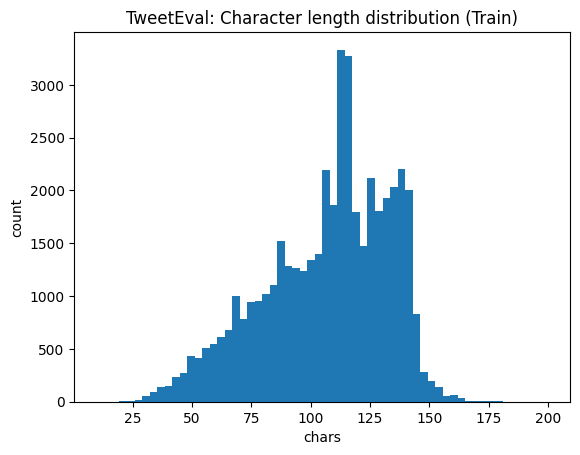


--- Label distribution ---


,count
label,
1,20673
2,17849
0,7093


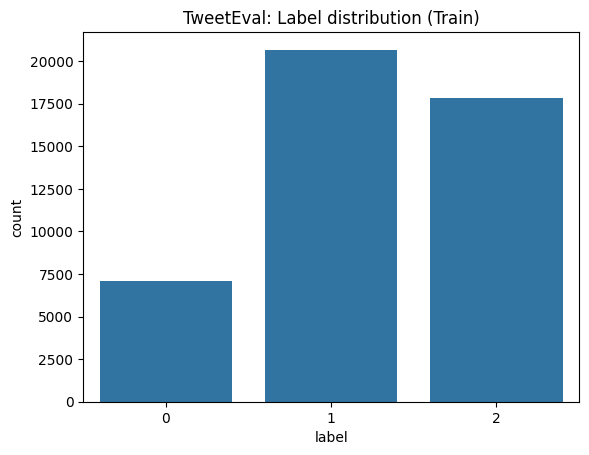


--- Top emojis ---


,emoji,count



--- Top hashtags ---


,hashtag,count
0,#raw,157
1,#mtvstars,91
2,#summerslam,85
3,#trndnl,78
4,#news,77
5,#wwe,77
6,#usopen,71
7,#bluejays,68
8,#1,62
9,#cubs,57



--- Top mentions ---


,mention,count
0,@user,16830
1,@4pm,3
2,@kbutter5,3
3,@youtube,3
4,@ufconfox,2
5,@thenotoriousmma,2
6,@rbkd,2
7,@galoppsport,2
8,@usopen,2
9,@espnstatsinfo,2


/tmp/ipython-input-3646956034.py:65: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pct_has_url = texts.str.contains(r"(https?://|www\.)", regex=True).mean()



--- Noise indicators ---


,metric,value
0,% has URL,0.002039
1,% has mention,0.294399
2,% has hashtag,0.186912
3,% has emoji,0.000000



--- Random samples ---


,text,label
11449,I forgot all about Ice Cube being in the movie...,0
26433,playoffs are finally set. Chardon plays warren...,1
33669,Are we just going to ignore the fact that Ice ...,1
33013,If you live in the South Orlando area\u002c be...,1
13399,First record of Colin Baker at the BBC: BBC2 s...,1
16963,Tomorrow night I'll be at Citi Field with the ...,2
2868,"""Frank Gifford died Sunday AM in his CT home. ...",2
12710,People talkin shit just wait I\u2019ll be in H...,0
8161,Intrigued by the mentions of alternate realiti...,1
1841,"""Gandhi:There may be violence, but then again ...",1


In [7]:
# =========================
# TweetEval EDA - Analysis (Train Set)
# =========================
import numpy as np
from collections import Counter

# Using df_tweet_eval_train directly
df_analyze = df_tweet_eval_train.copy()

text_col = _detect_text_col(df_analyze)
label_col = _detect_label_col(df_analyze, text_col)

print("=== TweetEval Sentiment EDA ===")
print("Text column:", text_col)
print("Label column:", label_col)

# 1. Missing / duplicates
print("\n--- Missing values (top) ---")
display(df_analyze.isna().mean().sort_values(ascending=False).head(10).to_frame("missing_ratio"))

dup_cnt = df_analyze.duplicated(subset=[text_col]).sum()
print(f"\nDuplicate texts: {dup_cnt} / {len(df_analyze)} ({dup_cnt/len(df_analyze):.2%})")

# 2. Text length stats
char_len, word_len = _basic_text_features(df_analyze[text_col])
print("\n--- Text length stats ---")
display(pd.DataFrame({
    "char_len": char_len.describe(percentiles=[.25,.5,.75,.9,.95,.99]),
    "word_len": word_len.describe(percentiles=[.25,.5,.75,.9,.95,.99]),
}))

plt.figure()
plt.hist(char_len, bins=60)
plt.title("TweetEval: Character length distribution (Train)")
plt.xlabel("chars"); plt.ylabel("count")
plt.show()

# 3. Label distribution
if label_col is not None:
    print("\n--- Label distribution ---")
    display(df_analyze[label_col].value_counts(dropna=False).to_frame("count"))

    plt.figure()
    sns.countplot(x=label_col, data=df_analyze)
    plt.title("TweetEval: Label distribution (Train)")
    plt.ylabel("count")
    plt.show()
else:
    print("\n[WARN] Could not detect label column.")

# 4. Social tokens
emoji_c, url_c, mention_c, hashtag_c = _extract_social_tokens(df_analyze[text_col])

print("\n--- Top emojis ---")
display(pd.DataFrame(emoji_c.most_common(20), columns=["emoji", "count"]))

print("\n--- Top hashtags ---")
display(pd.DataFrame(hashtag_c.most_common(20), columns=["hashtag", "count"]))

print("\n--- Top mentions ---")
display(pd.DataFrame(mention_c.most_common(20), columns=["mention", "count"]))

# 5. Noise indicators
texts = df_analyze[text_col].fillna("").astype(str)
pct_has_url = texts.str.contains(r"(https?://|www\.)", regex=True).mean()
pct_has_mention = texts.str.contains(r"@\w+", regex=True).mean()
pct_has_hashtag = texts.str.contains(r"#\w+", regex=True).mean()
pct_has_emoji = texts.apply(lambda t: len(emoji.emoji_list(t)) > 0).mean()

print("\n--- Noise indicators ---")
display(pd.DataFrame({
    "metric": ["% has URL", "% has mention", "% has hashtag", "% has emoji"],
    "value": [pct_has_url, pct_has_mention, pct_has_hashtag, pct_has_emoji]
}))

# 6. Random samples
cols_show = [text_col] + ([label_col] if label_col is not None else [])
print("\n--- Random samples ---")
display(df_analyze[cols_show].sample(10, random_state=42))

# **Pre-processing**

In [8]:
import re
import unicodedata
import ast
import numpy as np
import pandas as pd

RANDOM_SEED = 42
MAX_TEXT_LEN_CHARS = None

# Regex compiled
RE_URL = re.compile(r"(https?://\S+|www\.\S+)", flags=re.IGNORECASE)
RE_MENTION = re.compile(r"@\w+")
RE_HASHTAG = re.compile(r"#(\w+)")
RE_WHITESPACE = re.compile(r"\s+")

ENABLE_ELONGATION_NORM = False
RE_ELONG = re.compile(r"(.)\1{2,}", flags=re.IGNORECASE)

In [9]:
def normalize_social_text(
    text: str,
    keep_emoji: bool = True,      # emoji: giữ nguyên cho GoEmotions
    normalize_url: bool = True,
    normalize_mention: bool = True,
    normalize_hashtag: bool = True,  # #happy -> happy
    elongation_norm: bool = False,   # sooo -> soo
    max_chars: int | None = None,
) -> str:
    if text is None:
        return ""

    # Ensure string + unicode normalize
    t = str(text)
    t = unicodedata.normalize("NFKC", t)

    # URLs / mentions
    if normalize_url:
        t = RE_URL.sub("<URL>", t)
    if normalize_mention:
        t = RE_MENTION.sub("<USER>", t)

    # Hashtags: keep semantic word
    if normalize_hashtag:
        t = RE_HASHTAG.sub(r"\1", t)

    # Elongation (optional)
    if elongation_norm:
        t = RE_ELONG.sub(r"\1\1", t)

    # Whitespace normalize
    t = RE_WHITESPACE.sub(" ", t).strip()

    # hard truncate by chars
    if max_chars is not None and len(t) > max_chars:
        t = t[:max_chars].rstrip()

    return t


In [10]:
# =========================
# GoEmotions preprocessing (multi-label -> multi-hot)
# =========================

def parse_label_list(x):
    """
    GoEmotions labels in your EDA: list stored as string, e.g. "[27, 0]"
    """
    if isinstance(x, list):
        return x
    if isinstance(x, (np.ndarray, tuple)):
        return list(x)
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            return ast.literal_eval(s)
        except Exception:
            return []
    # fallback: single int-like
    try:
        return [int(s)]
    except Exception:
        return []

def labels_to_multihot(label_lists, num_labels: int):
    Y = np.zeros((len(label_lists), num_labels), dtype=np.int8)
    for i, labs in enumerate(label_lists):
        for lab in labs:
            if 0 <= int(lab) < num_labels:
                Y[i, int(lab)] = 1
    return Y

# 1) Concatenate splits (for consistent label space detection)
go_train = df_go_emotions_train.copy(); go_train["split"] = "train"
go_val   = df_go_emotions_validation.copy(); go_val["split"] = "validation"
go_test  = df_go_emotions_test.copy(); go_test["split"] = "test"
go_all = pd.concat([go_train, go_val, go_test], ignore_index=True)

# 2) Detect columns
GO_TEXT_COL = "text"
GO_LABEL_COL = "labels"

# 3) Parse labels
go_all["labels_list"] = go_all[GO_LABEL_COL].apply(parse_label_list)

# 4) Determine num_labels robustly
if "num_labels" in go_all.columns and pd.api.types.is_numeric_dtype(go_all["num_labels"]):
    num_labels_from_col = int(go_all["num_labels"].max())
else:
    num_labels_from_col = None

max_label_id = 0
if len(go_all["labels_list"]) > 0:
    max_label_id = max([max(l) for l in go_all["labels_list"] if len(l) > 0] + [0])

GO_NUM_LABELS = max(num_labels_from_col or 0, max_label_id + 1)
print("GoEmotions num_labels =", GO_NUM_LABELS)

# 5) Normalize text (keep emoji ON)
go_all["text_clean"] = go_all[GO_TEXT_COL].apply(
    lambda t: normalize_social_text(
        t,
        keep_emoji=True,
        normalize_url=True,
        normalize_mention=True,
        normalize_hashtag=True,
        elongation_norm=ENABLE_ELONGATION_NORM,
        max_chars=MAX_TEXT_LEN_CHARS
    )
)

# 6) Build multi-hot matrix
go_Y = labels_to_multihot(go_all["labels_list"].tolist(), GO_NUM_LABELS)
print("GoEmotions Y shape:", go_Y.shape)

# 7) Split back
go_train_clean = go_all[go_all["split"] == "train"].reset_index(drop=True)
go_val_clean   = go_all[go_all["split"] == "validation"].reset_index(drop=True)
go_test_clean  = go_all[go_all["split"] == "test"].reset_index(drop=True)

go_Y_train = go_Y[go_all["split"].values == "train"]
go_Y_val   = go_Y[go_all["split"].values == "validation"]
go_Y_test  = go_Y[go_all["split"].values == "test"]

print("GoEmotions splits:", len(go_train_clean), len(go_val_clean), len(go_test_clean))

GoEmotions num_labels = 28
GoEmotions Y shape: (54263, 28)
GoEmotions splits: 43410 5426 5427


In [11]:
# =========================
# TweetEval preprocessing (single-label)
# =========================

tw_train = df_tweet_eval_train.copy(); tw_train["split"] = "train"
tw_val   = df_tweet_eval_validation.copy(); tw_val["split"] = "validation"
tw_test  = df_tweet_eval_test.copy(); tw_test["split"] = "test"
tw_all = pd.concat([tw_train, tw_val, tw_test], ignore_index=True)

TW_TEXT_COL = "text"
TW_LABEL_COL = "label"

# Normalize text
# TweetEval EDA: emoji_count = 0, nhưng cứ giữ nguyên (không remove)
tw_all["text_clean"] = tw_all[TW_TEXT_COL].apply(
    lambda t: normalize_social_text(
        t,
        keep_emoji=True,
        normalize_url=True,
        normalize_mention=True,
        normalize_hashtag=True,
        elongation_norm=ENABLE_ELONGATION_NORM,
        max_chars=MAX_TEXT_LEN_CHARS
    )
)

# Labels as int
tw_all["label_int"] = tw_all[TW_LABEL_COL].astype(int)

# Split back
tw_train_clean = tw_all[tw_all["split"] == "train"].reset_index(drop=True)
tw_val_clean   = tw_all[tw_all["split"] == "validation"].reset_index(drop=True)
tw_test_clean  = tw_all[tw_all["split"] == "test"].reset_index(drop=True)

print("TweetEval splits:", len(tw_train_clean), len(tw_val_clean), len(tw_test_clean))
print("TweetEval label distribution (all):")
display(tw_all["label_int"].value_counts().sort_index().to_frame("count"))

TweetEval splits: 45615 2000 12284
TweetEval label distribution (all):


,count
label_int,
0,11377
1,27479
2,21043


In [12]:
# =========================
# Sanity checks (before/after + quick stats)
# =========================

def quick_text_stats(df, raw_col, clean_col, name):
    raw = df[raw_col].fillna("").astype(str)
    clean = df[clean_col].fillna("").astype(str)

    stats = pd.DataFrame({
        "raw_char_mean": [raw.str.len().mean()],
        "clean_char_mean": [clean.str.len().mean()],
        "raw_word_mean": [raw.str.split().apply(len).mean()],
        "clean_word_mean": [clean.str.split().apply(len).mean()],
        "pct_changed": [(raw != clean).mean()],
    }, index=[name])
    return stats

# GoEmotions checks
print("=== GoEmotions sanity ===")
display(pd.concat([
    quick_text_stats(go_train_clean, GO_TEXT_COL, "text_clean", "go_train"),
    quick_text_stats(go_val_clean, GO_TEXT_COL, "text_clean", "go_val"),
    quick_text_stats(go_test_clean, GO_TEXT_COL, "text_clean", "go_test"),
]))

print("GoEmotions Y shapes:", go_Y_train.shape, go_Y_val.shape, go_Y_test.shape)

# Show examples before/after
display(go_train_clean[[GO_TEXT_COL, "text_clean", "labels_list"]].sample(8, random_state=RANDOM_SEED))

# TweetEval checks
print("\n=== TweetEval sanity ===")
display(pd.concat([
    quick_text_stats(tw_train_clean, TW_TEXT_COL, "text_clean", "tw_train"),
    quick_text_stats(tw_val_clean, TW_TEXT_COL, "text_clean", "tw_val"),
    quick_text_stats(tw_test_clean, TW_TEXT_COL, "text_clean", "tw_test"),
]))

display(tw_train_clean[[TW_TEXT_COL, "text_clean", "label_int"]].sample(8, random_state=RANDOM_SEED))

=== GoEmotions sanity ===


,raw_char_mean,clean_char_mean,raw_word_mean,clean_word_mean,pct_changed
go_train,68.400875,68.335199,12.840175,12.840359,0.066068
go_val,68.243826,68.180243,12.790638,12.791928,0.063030
go_test,67.824765,67.760273,12.726000,12.726184,0.063571


GoEmotions Y shapes: (43410, 28) (5426, 28) (5427, 28)


,text,text_clean,labels_list
25759,The only way this works is if [NAME] is doing ...,The only way this works is if [NAME] is doing ...,[27]
22531,Access should be hindered it's getting destroyed.,Access should be hindered it's getting destroyed.,[3]
18418,Totally fair. All I was trying to remind every...,Totally fair. All I was trying to remind every...,[4]
31117,"I'm poly and jn the Raleigh area too, moved he...","I'm poly and jn the Raleigh area too, moved he...",[26]
5733,Naw man Asain men have an easier time. Most of...,Naw man Asain men have an easier time. Most of...,[1]
17987,That scene traumatized me the first time I wat...,That scene traumatized me the first time I wat...,[14]
5343,"No, some of us thought it was gross back then ...","No, some of us thought it was gross back then ...",[27]
7133,Sounds like they’re not responsible and should...,Sounds like they’re not responsible and should...,"[10, 22]"



=== TweetEval sanity ===


,raw_char_mean,clean_char_mean,raw_word_mean,clean_word_mean,pct_changed
tw_train,106.932851,106.833607,19.237444,19.237444,0.481815
tw_val,107.542000,107.488500,19.444500,19.444500,0.487500
tw_test,91.348095,90.502198,14.859492,14.859655,0.744709


,text,text_clean,label_int
11449,I forgot all about Ice Cube being in the movie...,I forgot all about Ice Cube being in the movie...,0
26433,playoffs are finally set. Chardon plays warren...,playoffs are finally set. Chardon plays warren...,1
33669,Are we just going to ignore the fact that Ice ...,Are we just going to ignore the fact that Ice ...,1
33013,If you live in the South Orlando area\u002c be...,If you live in the South Orlando area\u002c be...,1
13399,First record of Colin Baker at the BBC: BBC2 s...,First record of Colin Baker at the BBC: BBC2 s...,1
16963,Tomorrow night I'll be at Citi Field with the ...,Tomorrow night I'll be at Citi Field with the ...,2
2868,"""Frank Gifford died Sunday AM in his CT home. ...","""Frank Gifford died Sunday AM in his CT home. ...",2
12710,People talkin shit just wait I\u2019ll be in H...,People talkin shit just wait I\u2019ll be in H...,0


In [13]:
# # =========================
# # Save preprocessed data to Google Drive
# # =========================

# GO_OUT_DIR = "/content/drive/MyDrive/Colab Notebooks/dataset/processed/goemotion"
# TW_OUT_DIR = "/content/drive/MyDrive/Colab Notebooks/dataset/processed/tweeteval_sentiment"

# import os
# os.makedirs(GO_OUT_DIR, exist_ok=True)
# os.makedirs(TW_OUT_DIR, exist_ok=True)

# # Save GoEmotions text + labels_list
# go_train_clean[["text_clean", "labels_list", "id"]].to_csv(f"{GO_OUT_DIR}/train_clean.csv", index=False)
# go_val_clean[["text_clean", "labels_list", "id"]].to_csv(f"{GO_OUT_DIR}/validation_clean.csv", index=False)
# go_test_clean[["text_clean", "labels_list", "id"]].to_csv(f"{GO_OUT_DIR}/test_clean.csv", index=False)

# # Save multi-hot labels as npy (dùng training nhanh)
# np.save(f"{GO_OUT_DIR}/Y_train.npy", go_Y_train)
# np.save(f"{GO_OUT_DIR}/Y_val.npy", go_Y_val)
# np.save(f"{GO_OUT_DIR}/Y_test.npy", go_Y_test)

# # Save TweetEval
# tw_train_clean[["text_clean", "label_int"]].to_csv(f"{TW_OUT_DIR}/train_clean.csv", index=False)
# tw_val_clean[["text_clean", "label_int"]].to_csv(f"{TW_OUT_DIR}/validation_clean.csv", index=False)
# tw_test_clean[["text_clean", "label_int"]].to_csv(f"{TW_OUT_DIR}/test_clean.csv", index=False)

# print("✅ Saved preprocessed datasets to Drive.")
# print("GoEmotions:", GO_OUT_DIR)
# print("TweetEval:", TW_OUT_DIR)


# **Baseline TweetEval: TF-IDF + Logistic Regression**

In [14]:
# =========================
# BASELINE 1 — TweetEval: TF-IDF + Logistic Regression (single-label)
# Requires:
# - tw_train_clean, tw_val_clean, tw_test_clean (DataFrame)
#   columns: "text_clean", "label_int"
# =========================
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# 1) Prepare data
X_train_text = tw_train_clean["text_clean"].astype(str).tolist()
X_val_text   = tw_val_clean["text_clean"].astype(str).tolist()
X_test_text  = tw_test_clean["text_clean"].astype(str).tolist()

y_train = tw_train_clean["label_int"].astype(int).values
y_val   = tw_val_clean["label_int"].astype(int).values
y_test  = tw_test_clean["label_int"].astype(int).values

# 2) TF-IDF (word n-grams)
tfidf = TfidfVectorizer(
    lowercase=False,        # text_clean đã normalize
    ngram_range=(1, 2),
    max_features=50_000,
    min_df=2,
    sublinear_tf=True
)

X_train = tfidf.fit_transform(X_train_text)
X_val   = tfidf.transform(X_val_text)
X_test  = tfidf.transform(X_test_text)

# 3) Logistic Regression
clf = LogisticRegression(
    solver="liblinear",     # ổn định cho text
    max_iter=2000,
    class_weight="balanced",
    n_jobs=None
)

clf.fit(X_train, y_train)

# 4) Evaluation helpers
def eval_single_label(name, X, y_true):
    y_pred = clf.predict(X)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    print(f"\n[{name}] Macro-F1: {macro_f1:.4f} | Acc: {acc:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification report:\n", classification_report(y_true, y_pred, digits=4))

eval_single_label("TweetEval VAL", X_val, y_val)
eval_single_label("TweetEval TEST", X_test, y_test)


[TweetEval VAL] Macro-F1: 0.6366 | Acc: 0.6630
Confusion matrix:
 [[176 102  34]
 [125 590 154]
 [ 56 203 560]]
Classification report:
               precision    recall  f1-score   support

           0     0.4930    0.5641    0.5262       312
           1     0.6592    0.6789    0.6689       869
           2     0.7487    0.6838    0.7147       819

    accuracy                         0.6630      2000
   macro avg     0.6336    0.6423    0.6366      2000
weighted avg     0.6699    0.6630    0.6654      2000


[TweetEval TEST] Macro-F1: 0.5837 | Acc: 0.5966
Confusion matrix:
 [[2036 1574  362]
 [1148 3880  909]
 [ 176  786 1413]]
Classification report:
               precision    recall  f1-score   support

           0     0.6060    0.5126    0.5554      3972
           1     0.6218    0.6535    0.6373      5937
           2     0.5265    0.5949    0.5586      2375

    accuracy                         0.5966     12284
   macro avg     0.5847    0.5870    0.5837     12284
weighted 

# **Baseline GoEmotions: TF-IDF + One-vs-Rest Logistic Regression**

In [15]:
# =========================
# BASELINE 2 — GoEmotions: TF-IDF + OvR Logistic Regression (multi-label)
# Requires:
# - go_train_clean, go_val_clean, go_test_clean (DataFrame)
#   column: "text_clean"
# - go_Y_train, go_Y_val, go_Y_test (numpy arrays) multi-hot
# =========================
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

# 1) Prepare data
X_train_text = go_train_clean["text_clean"].astype(str).tolist()
X_val_text   = go_val_clean["text_clean"].astype(str).tolist()
X_test_text  = go_test_clean["text_clean"].astype(str).tolist()

Y_train = np.asarray(go_Y_train)
Y_val   = np.asarray(go_Y_val)
Y_test  = np.asarray(go_Y_test)

# 2) TF-IDF
tfidf_go = TfidfVectorizer(
    lowercase=False,
    ngram_range=(1, 2),
    max_features=80_000,   # GoEmotions nhiều nhãn hơn, vocab lớn hơn chút
    min_df=2,
    sublinear_tf=True
)

X_train = tfidf_go.fit_transform(X_train_text)
X_val   = tfidf_go.transform(X_val_text)
X_test  = tfidf_go.transform(X_test_text)

# 3) OvR Logistic Regression
base_lr = LogisticRegression(
    solver="liblinear",
    max_iter=2000,
    class_weight="balanced",
    n_jobs=None
)
ovr = OneVsRestClassifier(base_lr)

ovr.fit(X_train, Y_train)

# 4) Predict probabilities -> threshold -> binary
THRESH = 0.5  # baseline threshold (có thể tune bằng val sau)

def predict_multilabel(model, X, threshold=0.5):
    # decision_function cho LR ổn định hơn predict_proba với OvR
    scores = model.decision_function(X)  # shape [N, num_labels]
    # sigmoid
    probs = 1 / (1 + np.exp(-scores))
    Y_pred = (probs >= threshold).astype(int)
    return Y_pred, probs

def eval_multilabel(name, X, Y_true, threshold=0.5):
    Y_pred, _ = predict_multilabel(ovr, X, threshold=threshold)
    micro_f1 = f1_score(Y_true, Y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(Y_true, Y_pred, average="macro", zero_division=0)
    print(f"\n[{name}] Micro-F1: {micro_f1:.4f} | Macro-F1: {macro_f1:.4f} | threshold={threshold}")

eval_multilabel("GoEmotions VAL", X_val, Y_val, threshold=THRESH)
eval_multilabel("GoEmotions TEST", X_test, Y_test, threshold=THRESH)


[GoEmotions VAL] Micro-F1: 0.5067 | Macro-F1: 0.4534 | threshold=0.5

[GoEmotions TEST] Micro-F1: 0.4966 | Macro-F1: 0.4322 | threshold=0.5


In [16]:
# =========================
# Tune threshold on VALIDATION (GoEmotions baseline OvR LR)
# Cho mục tiêu: tối ưu Macro-F1 hoặc Micro-F1 trên VAL, rồi report trên TEST
# Requires (đã có từ cell baseline):
# - ovr (OneVsRestClassifier đã fit)
# - X_val, Y_val, X_test, Y_test (TF-IDF matrices + multi-hot arrays)
# =========================
import numpy as np
from sklearn.metrics import f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_with_threshold(model, X, threshold: float):
    scores = model.decision_function(X)      # [N, num_labels]
    probs = sigmoid(scores)
    Y_pred = (probs >= threshold).astype(int)
    return Y_pred

# 1) Grid thresholds to try
thresholds = np.arange(0.10, 0.91, 0.05)

rows = []
best_macro = (-1, None)  # (score, threshold)
best_micro = (-1, None)

for th in thresholds:
    Y_pred_val = predict_with_threshold(ovr, X_val, th)
    macro = f1_score(Y_val, Y_pred_val, average="macro", zero_division=0)
    micro = f1_score(Y_val, Y_pred_val, average="micro", zero_division=0)
    rows.append((th, macro, micro))

    if macro > best_macro[0]:
        best_macro = (macro, th)
    if micro > best_micro[0]:
        best_micro = (micro, th)

print("=== Threshold tuning on VAL ===")
print(f"Best Macro-F1 on VAL: {best_macro[0]:.4f} at threshold={best_macro[1]:.2f}")
print(f"Best Micro-F1 on VAL: {best_micro[0]:.4f} at threshold={best_micro[1]:.2f}")

# 2) Evaluate chosen thresholds on TEST (no tuning here!)
best_th_macro = best_macro[1]
best_th_micro = best_micro[1]

Y_pred_test_macro = predict_with_threshold(ovr, X_test, best_th_macro)
Y_pred_test_micro = predict_with_threshold(ovr, X_test, best_th_micro)

macro_test_macro = f1_score(Y_test, Y_pred_test_macro, average="macro", zero_division=0)
micro_test_macro = f1_score(Y_test, Y_pred_test_macro, average="micro", zero_division=0)

macro_test_micro = f1_score(Y_test, Y_pred_test_micro, average="macro", zero_division=0)
micro_test_micro = f1_score(Y_test, Y_pred_test_micro, average="micro", zero_division=0)

print("\n=== Report on TEST using VAL-selected threshold ===")
print(f"[Using best-Macro threshold={best_th_macro:.2f}] TEST Macro-F1={macro_test_macro:.4f} | Micro-F1={micro_test_macro:.4f}")
print(f"[Using best-Micro threshold={best_th_micro:.2f}] TEST Macro-F1={macro_test_micro:.4f} | Micro-F1={micro_test_micro:.4f}")

# 3) Show top thresholds table (sorted)
rows_sorted_by_macro = sorted(rows, key=lambda x: x[1], reverse=True)[:10]
rows_sorted_by_micro = sorted(rows, key=lambda x: x[2], reverse=True)[:10]

print("\nTop-10 thresholds by VAL Macro-F1:")
for th, ma, mi in rows_sorted_by_macro:
    print(f"th={th:.2f} | macro={ma:.4f} | micro={mi:.4f}")

print("\nTop-10 thresholds by VAL Micro-F1:")
for th, ma, mi in rows_sorted_by_micro:
    print(f"th={th:.2f} | macro={ma:.4f} | micro={mi:.4f}")

=== Threshold tuning on VAL ===
Best Macro-F1 on VAL: 0.4611 at threshold=0.55
Best Micro-F1 on VAL: 0.5122 at threshold=0.55

=== Report on TEST using VAL-selected threshold ===
[Using best-Macro threshold=0.55] TEST Macro-F1=0.4387 | Micro-F1=0.5036
[Using best-Micro threshold=0.55] TEST Macro-F1=0.4387 | Micro-F1=0.5036

Top-10 thresholds by VAL Macro-F1:
th=0.55 | macro=0.4611 | micro=0.5122
th=0.60 | macro=0.4611 | micro=0.5076
th=0.65 | macro=0.4555 | micro=0.4914
th=0.50 | macro=0.4534 | micro=0.5067
th=0.70 | macro=0.4434 | micro=0.4631
th=0.45 | macro=0.4362 | micro=0.4877
th=0.40 | macro=0.4178 | micro=0.4639
th=0.75 | macro=0.4172 | micro=0.4289
th=0.35 | macro=0.3941 | micro=0.4277
th=0.80 | macro=0.3901 | micro=0.3881

Top-10 thresholds by VAL Micro-F1:
th=0.55 | macro=0.4611 | micro=0.5122
th=0.60 | macro=0.4611 | micro=0.5076
th=0.50 | macro=0.4534 | micro=0.5067
th=0.65 | macro=0.4555 | micro=0.4914
th=0.45 | macro=0.4362 | micro=0.4877
th=0.40 | macro=0.4178 | micro=0.

# **Tokenizer**

In [17]:
from transformers import AutoTokenizer
import torch

MAX_LENGTH = 128

# ---------
# Load tokenizers
# ---------
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)

# BERTweet: use_fast=False + Twitter-style placeholders
bertweet_tokenizer = AutoTokenizer.from_pretrained(
    "vinai/bertweet-base",
    use_fast=False
)

def to_bertweet_format(text: str) -> str:
    """
    Convert placeholders to BERTweet convention:
    <USER>  -> @USER
    <URL>   -> HTTPURL
    """
    if text is None:
        return ""
    return str(text).replace("<USER>", "@USER").replace("<URL>", "HTTPURL")


def tokenize_texts(tokenizer, texts, max_length=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

In [18]:
# ======================================================
# GoEmotions — RoBERTa tokenization
# ======================================================
go_train_texts = go_train_clean["text_clean"].astype(str).tolist()
go_val_texts   = go_val_clean["text_clean"].astype(str).tolist()
go_test_texts  = go_test_clean["text_clean"].astype(str).tolist()

go_enc_train = tokenize_texts(roberta_tokenizer, go_train_texts, MAX_LENGTH)
go_enc_val   = tokenize_texts(roberta_tokenizer, go_val_texts, MAX_LENGTH)
go_enc_test  = tokenize_texts(roberta_tokenizer, go_test_texts, MAX_LENGTH)

print("GoEmotions (RoBERTa) tokenized:")
print("Train:", go_enc_train["input_ids"].shape)
print("Val  :", go_enc_val["input_ids"].shape)
print("Test :", go_enc_test["input_ids"].shape)

# ======================================================
# TweetEval — BERTweet tokenization
# ======================================================
tw_train_texts = [to_bertweet_format(t) for t in tw_train_clean["text_clean"].astype(str)]
tw_val_texts   = [to_bertweet_format(t) for t in tw_val_clean["text_clean"].astype(str)]
tw_test_texts  = [to_bertweet_format(t) for t in tw_test_clean["text_clean"].astype(str)]

tw_enc_train = tokenize_texts(bertweet_tokenizer, tw_train_texts, MAX_LENGTH)
tw_enc_val   = tokenize_texts(bertweet_tokenizer, tw_val_texts, MAX_LENGTH)
tw_enc_test  = tokenize_texts(bertweet_tokenizer, tw_test_texts, MAX_LENGTH)

print("\nTweetEval (BERTweet) tokenized:")
print("Train:", tw_enc_train["input_ids"].shape)
print("Val  :", tw_enc_val["input_ids"].shape)
print("Test :", tw_enc_test["input_ids"].shape)

GoEmotions (RoBERTa) tokenized:
Train: torch.Size([43410, 128])
Val  : torch.Size([5426, 128])
Test : torch.Size([5427, 128])

TweetEval (BERTweet) tokenized:
Train: torch.Size([45615, 128])
Val  : torch.Size([2000, 128])
Test : torch.Size([12284, 128])


In [19]:
idx = 0
print("\n--- Decode sanity check ---")
print("Go (RoBERTa):")
print(roberta_tokenizer.decode(go_enc_train["input_ids"][idx], skip_special_tokens=True))

print("\nTweet (BERTweet):")
print(bertweet_tokenizer.decode(tw_enc_train["input_ids"][idx], skip_special_tokens=True))


--- Decode sanity check ---
Go (RoBERTa):
My favourite food is anything I didn't have to cook myself.

Tweet (BERTweet):
"QT @USER In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. HappyBirthdayRemusLupin"


# **Dataset + DataLoader**

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_WORKERS = 2

In [34]:
class GoEmotionsDataset(Dataset):
    """
    Dataset cho GoEmotions (multi-label)
    - input_ids: [128]
    - attention_mask: [128]
    - labels: multi-hot vector [num_labels]
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, idx):
        item = {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }
        return item

In [35]:
go_train_dataset = GoEmotionsDataset(go_enc_train, go_Y_train)
go_val_dataset   = GoEmotionsDataset(go_enc_val,   go_Y_val)
go_test_dataset  = GoEmotionsDataset(go_enc_test,  go_Y_test)

go_train_loader = DataLoader(
    go_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

go_val_loader = DataLoader(
    go_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

go_test_loader = DataLoader(
    go_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print("GoEmotions loaders ready")

GoEmotions loaders ready


In [36]:
class TweetEvalDataset(Dataset):
    """
    Dataset cho TweetEval (single-label)
    - input_ids: [128]
    - attention_mask: [128]
    - labels: int
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, idx):
        item = {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }
        return item

In [37]:
tw_train_dataset = TweetEvalDataset(
    tw_enc_train,
    tw_train_clean["label_int"].values
)

tw_val_dataset = TweetEvalDataset(
    tw_enc_val,
    tw_val_clean["label_int"].values
)

tw_test_dataset = TweetEvalDataset(
    tw_enc_test,
    tw_test_clean["label_int"].values
)

tw_train_loader = DataLoader(
    tw_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

tw_val_loader = DataLoader(
    tw_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

tw_test_loader = DataLoader(
    tw_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print("TweetEval loaders ready")

TweetEval loaders ready


In [38]:
batch = next(iter(go_train_loader))
print("GoEmotions batch:")
print("input_ids:", batch["input_ids"].shape)
print("attention_mask:", batch["attention_mask"].shape)
print("labels:", batch["labels"].shape)

batch = next(iter(tw_train_loader))
print("\nTweetEval batch:")
print("input_ids:", batch["input_ids"].shape)
print("attention_mask:", batch["attention_mask"].shape)
print("labels:", batch["labels"].shape)

GoEmotions batch:
input_ids: torch.Size([32, 128])
attention_mask: torch.Size([32, 128])
labels: torch.Size([32, 28])

TweetEval batch:
input_ids: torch.Size([32, 128])
attention_mask: torch.Size([32, 128])
labels: torch.Size([32])


# **BERTweet cho TweetEval (Sentiment – single-label)**

In [39]:
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [40]:
MODEL_NAME = "vinai/bertweet-base"
NUM_LABELS = 3  # negative / neutral / positive

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

model.to(DEVICE)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [41]:
EPOCHS = 3
LR = 2e-5

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(tw_train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
)

In [42]:
def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    for batch in tqdm(loader, leave=False):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [43]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()

    all_preds = []
    all_labels = []

    for batch in tqdm(loader, leave=False):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)

    return macro_f1, acc

In [44]:
best_val_f1 = 0.0

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch + 1}/{EPOCHS} ===")

    train_loss = train_one_epoch(
        model,
        tw_train_loader,
        optimizer,
        scheduler,
    )

    val_f1, val_acc = evaluate(model, tw_val_loader)

    print(f"Train loss: {train_loss:.4f}")
    print(f"VAL Macro-F1: {val_f1:.4f} | Acc: {val_acc:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_bertweet_tweeteval.pt")
        print("✅ Saved best model")


=== Epoch 1/3 ===


  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train loss: 0.6745
VAL Macro-F1: 0.7320 | Acc: 0.7465
✅ Saved best model

=== Epoch 2/3 ===


  0%|          | 0/1426 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2297f571a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Exception ignored in: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2297f571a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/63 [00:00<?, ?it/s]

Train loss: 0.4880
VAL Macro-F1: 0.7324 | Acc: 0.7500
✅ Saved best model

=== Epoch 3/3 ===


  0%|          | 0/1426 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2297f571a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2297f571a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/63 [00:00<?, ?it/s]

Train loss: 0.3788
VAL Macro-F1: 0.7442 | Acc: 0.7560
✅ Saved best model


In [45]:
model.load_state_dict(torch.load("best_bertweet_tweeteval.pt"))

test_f1, test_acc = evaluate(model, tw_test_loader)

print("\n=== TweetEval TEST (BERTweet) ===")
print(f"Macro-F1: {test_f1:.4f}")
print(f"Accuracy: {test_acc:.4f}")

  0%|          | 0/384 [00:00<?, ?it/s]


=== TweetEval TEST (BERTweet) ===
Macro-F1: 0.7189
Accuracy: 0.7173


# **GoEmotions với RoBERTa (multi-label)**

In [46]:
import os, random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from tqdm.auto import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Device: cuda


In [47]:
MODEL_NAME = "roberta-base"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

NUM_LABELS = int(go_Y_train.shape[1])
print("GoEmotions num_labels:", NUM_LABELS)

EPOCHS = 3
LR = 2e-5
BATCH_SIZE = 32
NUM_WORKERS = 0   # Colab ổn định

GoEmotions num_labels: 28


In [48]:
class GoEmotionsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = labels.astype(np.float32)  # BCEWithLogitsLoss cần float
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float32),
        }
        return item

go_train_ds = GoEmotionsDataset(go_train_clean["text_clean"], go_Y_train, tokenizer, MAX_LEN)
go_val_ds   = GoEmotionsDataset(go_val_clean["text_clean"],   go_Y_val,   tokenizer, MAX_LEN)
go_test_ds  = GoEmotionsDataset(go_test_clean["text_clean"],  go_Y_test,  tokenizer, MAX_LEN)

print(len(go_train_ds), len(go_val_ds), len(go_test_ds))

43410 5426 5427


In [49]:
go_train_loader = DataLoader(
    go_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

go_val_loader = DataLoader(
    go_val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

go_test_loader = DataLoader(
    go_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print("Batches(train/val/test):", len(go_train_loader), len(go_val_loader), len(go_test_loader))

Batches(train/val/test): 1357 170 170


In [50]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification",  # quan trọng
)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(go_train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

print("Total steps:", total_steps)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 4071


In [51]:
def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, leave=False):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [52]:
@torch.no_grad()
def evaluate_multilabel(model, loader, threshold=0.5):
    model.eval()
    all_probs = []
    all_true = []

    for batch in tqdm(loader, leave=False):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = torch.sigmoid(logits).cpu().numpy()  # [N, L]
        all_probs.append(probs)
        all_true.append(labels)

    P = np.concatenate(all_probs, axis=0)
    Y = np.concatenate(all_true, axis=0).astype(int)

    Y_pred = (P >= threshold).astype(int)

    micro = f1_score(Y, Y_pred, average="micro", zero_division=0)
    macro = f1_score(Y, Y_pred, average="macro", zero_division=0)

    return micro, macro

In [53]:
BEST_PATH = "best_roberta_goemotions.pt"
best_val_macro = -1.0
best_threshold = 0.5

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

    train_loss = train_one_epoch(model, go_train_loader, optimizer, scheduler)
    val_micro, val_macro = evaluate_multilabel(model, go_val_loader, threshold=0.5)

    print(f"Train loss: {train_loss:.4f}")
    print(f"VAL  Micro-F1: {val_micro:.4f} | Macro-F1: {val_macro:.4f} | th=0.50")

    if val_macro > best_val_macro:
        best_val_macro = val_macro
        torch.save(model.state_dict(), BEST_PATH)
        print("✅ Saved best model")


=== Epoch 1/3 ===


  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

Train loss: 0.1787
VAL  Micro-F1: 0.4734 | Macro-F1: 0.1930 | th=0.50
✅ Saved best model

=== Epoch 2/3 ===


  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

Train loss: 0.0942
VAL  Micro-F1: 0.5511 | Macro-F1: 0.3344 | th=0.50
✅ Saved best model

=== Epoch 3/3 ===


  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

Train loss: 0.0836
VAL  Micro-F1: 0.5652 | Macro-F1: 0.3744 | th=0.50
✅ Saved best model


In [54]:
# Load best checkpoint first
model.load_state_dict(torch.load(BEST_PATH))

thresholds = np.arange(0.10, 0.91, 0.05)
best = (-1, None, None)  # (macro, micro, th)

for th in thresholds:
    val_micro, val_macro = evaluate_multilabel(model, go_val_loader, threshold=th)
    if val_macro > best[0]:
        best = (val_macro, val_micro, th)

print("\n=== Best threshold on VAL ===")
print(f"Best VAL Macro-F1={best[0]:.4f} | Micro-F1={best[1]:.4f} at threshold={best[2]:.2f}")

best_threshold = best[2]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]


=== Best threshold on VAL ===
Best VAL Macro-F1=0.4464 | Micro-F1=0.5974 at threshold=0.20


In [55]:
test_micro, test_macro = evaluate_multilabel(model, go_test_loader, threshold=best_threshold)

print("\n=== GoEmotions TEST (RoBERTa) ===")
print(f"Threshold: {best_threshold:.2f}")
print(f"Micro-F1 : {test_micro:.4f}")
print(f"Macro-F1 : {test_macro:.4f}")

  0%|          | 0/170 [00:00<?, ?it/s]


=== GoEmotions TEST (RoBERTa) ===
Threshold: 0.20
Micro-F1 : 0.5924
Macro-F1 : 0.4395
